In [93]:
import cmsisdsp as dsp
import numpy as np
from scipy import signal
from scipy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt
import pandas as pd

from filt_plot_funcs import *

fs = 200


In [94]:
def normalize(xn):
    return (xn - np.min(xn)) / (np.max(xn) - np.min(xn))

def quantizeTo12Bit(xn):
    yn = (xn * (1 << 11)) // 1
    yn /= 1 << 11
    return yn

def convertToFixedPoint_Q31(xn):
    xn /= np.max(np.abs(xn))
    xn = ( xn * (1 << 31) ) // 1
    return np.array(xn, dtype=int)


In [95]:
def printBiquadInArmFormat(sos):
    sos = np.float32(sos)
    sos = np.delete(sos, 3, 1)
    sos[:, 3:] *= -1
    
    print("{", end='\n')
    for section in sos:
        for idx, val in enumerate(section):
            if idx == 0 or idx == 3: print(" " * 4, end='')
            print(f"{val}f, ", end='')
            if idx == 2: print("\n", end='')
            
        print("\n", end='')
    
    print("};", end='')
    return

## DAQ

### Low Pass Filter

In [96]:
sos1 = signal.iirfilter(N = 8, Wn = 40, btype="lowpass", rs=10, ftype='cheby2', fs=fs, output='sos')
printBiquadInArmFormat(sos1)


{
    0.33315151929855347f, 0.5766809582710266f, 0.33315151929855347f, 
    -0.9251470565795898f, -0.3086468279361725f, 
    1.0f, 0.5240882635116577f, 1.0f, 
    -0.2858136296272278f, -0.5249051451683044f, 
    1.0f, -0.2681707739830017f, 1.0f, 
    0.29658612608909607f, -0.745910108089447f, 
    1.0f, -0.5827286839485168f, 1.0f, 
    0.6055136919021606f, -0.9191300272941589f, 
};

abs(p) = [0.55555992 0.55555992 0.72450339 0.72450339 0.86366088 0.86366088
 0.9587127  0.9587127 ]


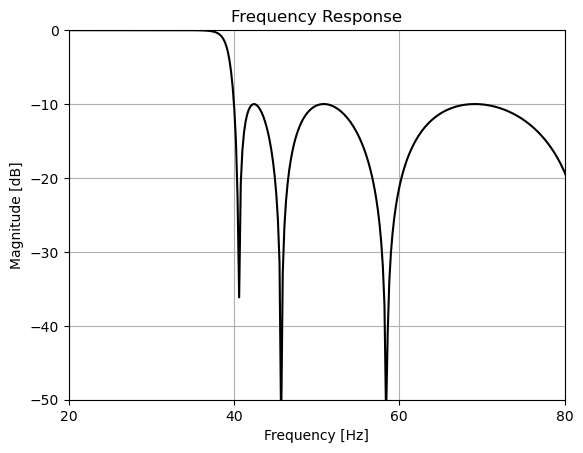

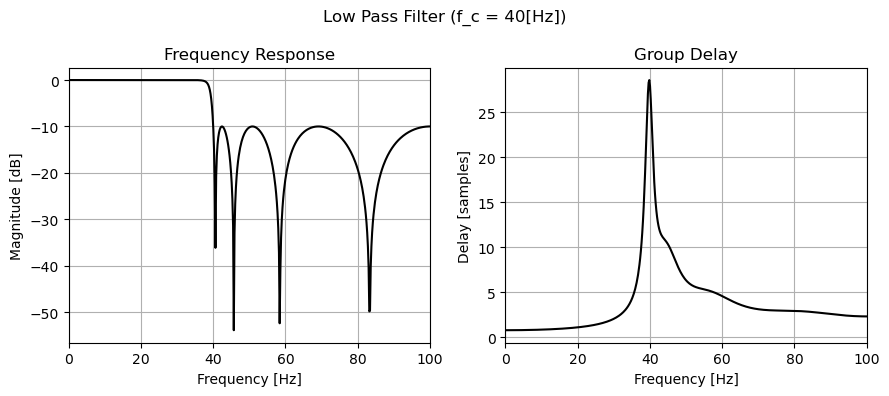

<Figure size 640x480 with 0 Axes>

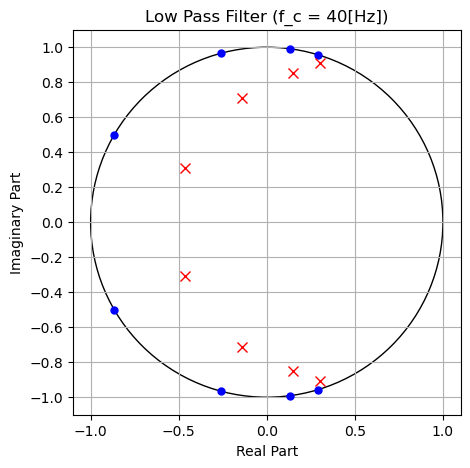

In [112]:
z1, p1, k1 = signal.sos2zpk(sos1)
print(f"abs(p) = {np.abs(p1)}")

b1, a1 = signal.sos2tf(sos1)

plot_freq_resp(b1, a1, fs=fs, in_dB=True)
plt.xlim([20, 80]); plt.ylim([-50, 0])

plot_domain_f(b1, a1, fs=fs, in_dB=True, filt_name="Low Pass Filter (f_c = 40[Hz])")
plot_pole_zero(b1, a1, filt_name="Low Pass Filter (f_c = 40[Hz])")

### IIR Notch Filter

In [98]:
sos2 = signal.iirfilter(N=6, Wn=[59, 61], btype='bandstop', output='sos', fs=fs)
printBiquadInArmFormat(sos2)


{
    0.8856732845306396f, 0.5476464033126831f, 0.8856732845306396f, 
    -0.5850160717964172f, -0.9409302473068237f, 
    1.0f, 0.6183391213417053f, 1.0f, 
    -0.615153431892395f, -0.9412328004837036f, 
    1.0f, 0.6183391213417053f, 1.0f, 
    -0.5631667971611023f, -0.9562366008758545f, 
    1.0f, 0.6183391213417053f, 1.0f, 
    -0.6460562348365784f, -0.9568508863449097f, 
    1.0f, 0.6183391213417053f, 1.0f, 
    -0.5554963946342468f, -0.9837208390235901f, 
    1.0f, 0.6183391213417053f, 1.0f, 
    -0.6700929999351501f, -0.9840363264083862f, 
};

abs(p) = [0.97001559 0.97001559 0.97017153 0.97017153 0.97787352 0.97787352
 0.97818754 0.97818754 0.99182701 0.99182701 0.99198604 0.99198604]


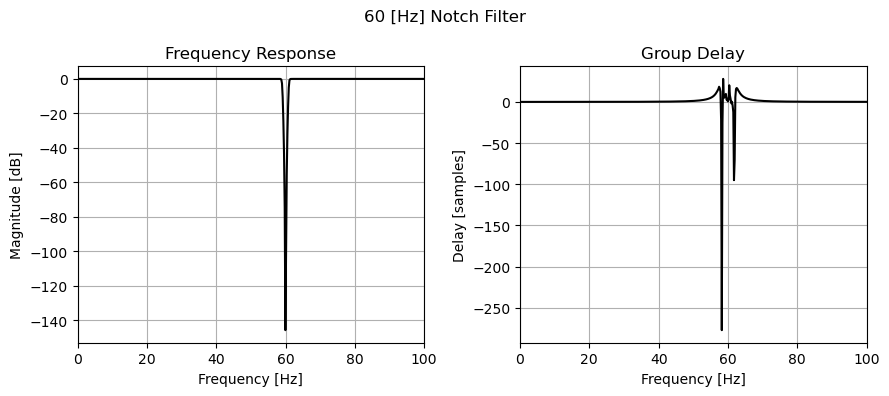

<Figure size 640x480 with 0 Axes>

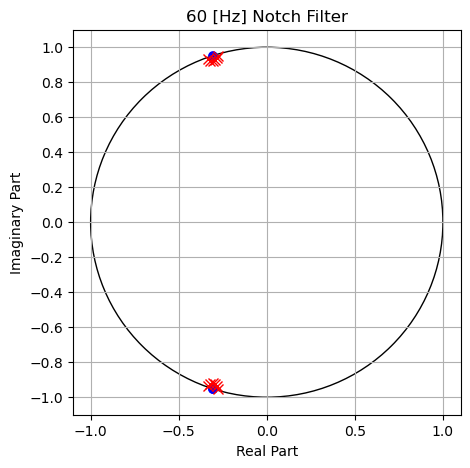

In [99]:
z2, p2, k2 = signal.sos2zpk(sos2)
print(f"abs(p) = {np.abs(p2)}")

b2, a2 = signal.sos2tf(sos2)
plot_domain_f(b2, a2, fs=fs, in_dB=True, filt_name="60 [Hz] Notch Filter")
plot_pole_zero(b2, a2, filt_name="60 [Hz] Notch Filter")

### Overall Filter

In [110]:
z3 = np.concatenate([z1, z2])
p3 = np.concatenate([p1, p2])
k3 = k1 * k2

print(np.sort(np.abs(p3)))

[0.55555992 0.55555992 0.72450339 0.72450339 0.86366088 0.86366088
 0.9587127  0.9587127  0.97001559 0.97001559 0.97017153 0.97017153
 0.97787352 0.97787352 0.97818754 0.97818754 0.99182701 0.99182701
 0.99198604 0.99198604]


In [111]:
sos3 = signal.zpk2sos(z3, p3, k3)
printBiquadInArmFormat(sos3)

{
    0.29506340622901917f, 0.510750949382782f, 0.29506340622901917f, 
    -0.9251470565795898f, -0.3086468279361725f, 
    1.0f, 0.6183391213417053f, 1.0f, 
    -0.2858136296272278f, -0.5249051451683044f, 
    1.0f, -0.2681707739830017f, 1.0f, 
    0.29658612608909607f, -0.745910108089447f, 
    1.0f, -0.5827286839485168f, 1.0f, 
    0.6055136919021606f, -0.9191300272941589f, 
    1.0f, 0.6183391213417053f, 1.0f, 
    -0.5850160717964172f, -0.9409302473068237f, 
    1.0f, 0.6183391213417053f, 1.0f, 
    -0.615153431892395f, -0.9412328004837036f, 
    1.0f, 0.6183391213417053f, 1.0f, 
    -0.5631667971611023f, -0.9562366008758545f, 
    1.0f, 0.6183391213417053f, 1.0f, 
    -0.6460562348365784f, -0.9568508863449097f, 
    1.0f, 0.5240882635116577f, 1.0f, 
    -0.5554963946342468f, -0.9837208390235901f, 
    1.0f, 0.6183391213417053f, 1.0f, 
    -0.6700929999351501f, -0.9840363264083862f, 
};

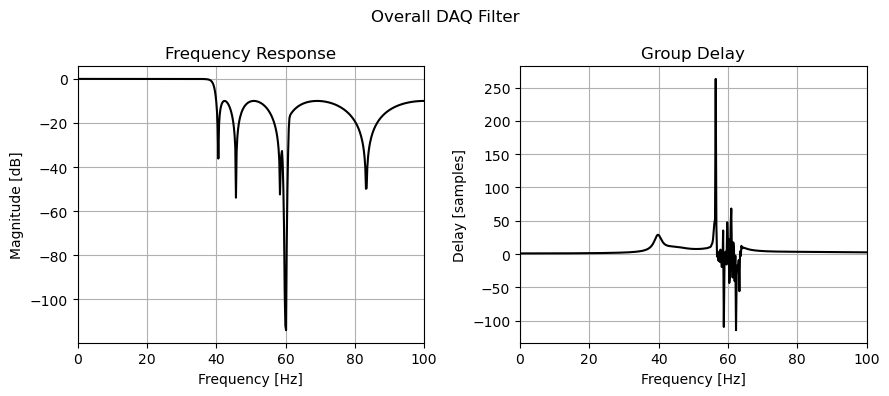

<Figure size 640x480 with 0 Axes>

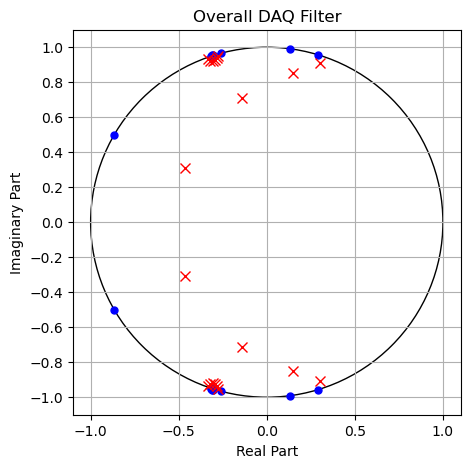

In [106]:
b3, a3 = signal.sos2tf(sos3)

plot_domain_f(b3, a3, fs=fs, in_dB=True, filt_name="Overall DAQ Filter")
plot_pole_zero(b3, a3, filt_name="Overall DAQ Filter")

### DAQ Filter Test

In [100]:
data = pd.read_csv("../../data/101.csv")
data.describe()

,Unnamed: 0,0
count,361111.000000,361111.000000
mean,180555.000000,-0.284222
std,104243.910866,0.261132
min,0.000000,-3.165415
25%,90277.500000,-0.401950
50%,180555.000000,-0.329274
75%,270832.500000,-0.235140
max,361110.000000,2.418641


In [101]:
# Convert to fixed-point
xn = np.array(data.iloc[:,1])

N = len(xn)
n = np.linspace(0, N, N)

# Generate 60 [Hz] noise
t = n / fs
noise = np.sin(2 * np.pi * 60 * t)

# Filter
yn = signal.lfilter(b, a, xn + noise)


In [102]:
pd.DataFrame(xn).describe()

,0
count,361111.000000
mean,-0.284222
std,0.261132
min,-3.165415
25%,-0.401950
50%,-0.329274
75%,-0.235140
max,2.418641


In [103]:
Xf = rfft(xn, N)
X1f = rfft(xn + noise, N)
Yf = rfft(yn, N)

f = rfftfreq(N, 1/fs)

/Users/bryanmcelvy/opt/anaconda3/envs/ecg_hrm_py/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/bryanmcelvy/opt/anaconda3/envs/ecg_hrm_py/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


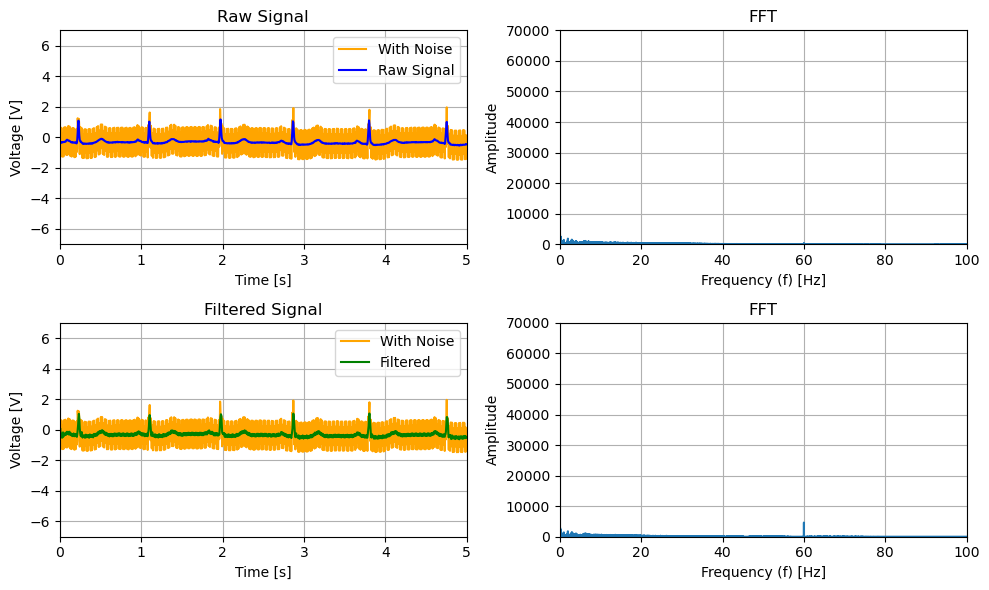

In [104]:
fig, axs = plt.subplots(2, 2, tight_layout=True, figsize=[10, 6])

start = 0 * fs
duration = 5 * fs
end = start + duration

plt.sca(axs[0][0])
plt.title("Raw Signal")
plt.plot(n[start:end]/fs, (xn + noise)[start:end], color='orange', label="With Noise")
plt.plot(n[start:end]/fs, xn[start:end], color='blue', label="Raw Signal")

plt.sca(axs[0][1])
plt.title("FFT")
plt.plot(f, Xf)

plt.sca(axs[1][0])
plt.title("Filtered Signal")
plt.plot(n[start:end]/fs, (xn + noise)[start:end], color='orange', label="With Noise")
plt.plot(n[start:end]/fs, yn[start:end], color='green', label="Filtered")

plt.sca(axs[1][1])
plt.title("FFT")
plt.plot(f, Yf)

for row in axs:
    for idx, ax in enumerate(row):
        ax.grid(True)
        if idx == 0: 
            ax.set_xlim(np.array([start, end])/fs)
            ax.set_ylim(np.array([-1, 1]) * 7)
            ax.set_xlabel("Time [s]")
            ax.set_ylabel("Voltage [V]")
            ax.legend()
        else: 
            ax.set_xlim([0, 100])
            ax.set_ylim([0, 70000])
            ax.set_xlabel("Frequency (f) [Hz]")
            ax.set_ylabel("Amplitude")


## QRS

### QRS LPF

In [ ]:
b, a = signal.iirfilter(N=2, Wn=20, btype='lowpass', ftype='butter', fs=fs)
b = np.single(b)
a = np.single(a)

print(f"b = {b}\na = {a}")


In [ ]:
sos = signal.tf2sos(b, a).astype(dtype=np.float16)

print(f"Unformatted:\n{sos}")
print(f"\nFormatted:", end='')
for section_num in range(np.shape(sos)[0]):
    print("\n")
    for coeff in range(np.shape(sos)[1]):
        print(sos[section_num][coeff], end=", ")

In [ ]:
plot_domain_t(b, a)

_, [ax1, ax2] = plt.subplots(1, 2, figsize=[9, 4], tight_layout=True)

plot_domain_f(b, a, fs=fs, ax1=ax1, ax2=ax2)

for ax in [ax1, ax2]:
    plt.sca(ax)
    plt.axvline(x=30, linestyle='dashed', color='r', label="Cutoff Frequency")
    plt.legend()
    
plot_pole_zero(b, a)

### QRS HPF

In [ ]:
b, a = signal.iirfilter(N=2, Wn=12, btype='highpass', ftype='butter', fs=fs)
b = np.single(b)
a = np.single(a)

print(f"b = {b}\na = {a}")


In [ ]:
sos = signal.tf2sos(b, a).astype(dtype=np.float16)

print(f"Unformatted:\n{sos}")
print(f"\nFormatted:", end='')
for section_num in range(np.shape(sos)[0]):
    print("\n")
    for coeff in range(np.shape(sos)[1]):
        print(sos[section_num][coeff], end=", ")

In [ ]:
plot_domain_t(b, a)

_, [ax1, ax2] = plt.subplots(1, 2, figsize=[9, 4], tight_layout=True)

plot_domain_f(b, a, fs=fs, ax1=ax1, ax2=ax2)

for ax in [ax1, ax2]:
    plt.sca(ax)
    plt.axvline(x=30, linestyle='dashed', color='r', label="Cutoff Frequency")
    plt.legend()
    
plot_pole_zero(b, a)

### QRS Derivative Filter

In [ ]:
b = np.array( [1, 2, 0, -2, -1] ) / 8
a = np.zeros(np.shape(b))
a[0] = 1

b = np.single(b)
a = np.single(a)

print(f"b = {b}\na = {a}")

In [ ]:
plot_domain_t(b, a)

_, [ax1, ax2] = plt.subplots(1, 2, figsize=[9, 4], tight_layout=True)

plot_domain_f(b, a, fs=fs, ax1=ax1, ax2=ax2)

for ax in [ax1, ax2]:
    plt.sca(ax)
    plt.axvline(x=30, linestyle='dashed', color='r', label="Cutoff Frequency")
    plt.legend()
    
plot_pole_zero(b, a)

### QRS MA Filter

In [ ]:
M = 15
b = np.ones(M) / M
a = np.zeros(np.shape(b))
a[0] = 1

b = np.single(b)
a = np.single(a)

print(f"b = {b}\na = {a}")

In [ ]:
plot_domain_t(b, a)

_, [ax1, ax2] = plt.subplots(1, 2, figsize=[9, 4], tight_layout=True)

plot_domain_f(b, a, fs=fs, ax1=ax1, ax2=ax2)

for ax in [ax1, ax2]:
    plt.sca(ax)
    plt.axvline(x=30, linestyle='dashed', color='r', label="Cutoff Frequency")
    plt.legend()
    
plot_pole_zero(b, a)